## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to get some practice working with the difficulties of these.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
#importing libraries needed
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#setting the seed to assure I get the same answers on quizzes
random.seed(42)

`1.` First things first, I need to read in the `ab_data.csv` data. I will be storing it in `df`. 

a. Reading in the dataset and taking a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Using the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean() * 100

11.965919355605511

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
ctr_new = df.query('group == "control" and landing_page == "new_page"')
trt_old = df.query('group == "treatment" and landing_page == "old_page"')
len(ctr_new) + len(trt_old)

3893

f. Checking for missing values.

In [7]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. To correct this, we will be creating a new dataset called **df2**.

In [8]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [9]:
# double checking all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Cleaning **df2** and understanding the dataset as a whole.

a. How many unique **user_id**s are in **df2**?

In [10]:
#number of unique users
df2.user_id.nunique()

290584

In [11]:
#number of all users
len(df2)

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removing **one** of the rows with a duplicate **user_id**, but keeping the dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(['user_id'], keep='last')

In [15]:
#checking to see if the change worked
len(df2)

290584

`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Considering the results from parts (a) through (d) above, and explaining below whether I think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**In short, I would say that the new page does not lead to more conversions. The probability of an individual converted on the old page is higher than conversion rates on the new page, however the difference is small. The chance an individual recieves the new page is 50% meaning that individuals recieved an equal amount of the new page and old page. With the conversion rate being similar of 12% for the old page and 11.9% for the new page, it would seem that the different page has little to no effect on a viewer, however, this is all surface probability and I need to dig deeper to know the real answer.**

<a id='ab_test'></a>
### Part II - A/B Test

`1` **Hypothesis**:

$H_{0}$ : $p_{new}$ <= $p_{old}$

$H_{1}$ : $p_{new}$ > $p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

In [20]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null and storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1 - p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null and storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0,1], n_old, p = [p_old, 1 - p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 0])

g. Finding $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [27]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.0008787821206311941

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above and storing all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plotting a histogram of the **p_diffs**.

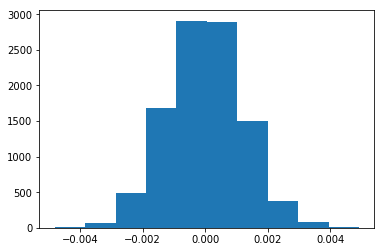

In [29]:
plt.hist(p_diffs);

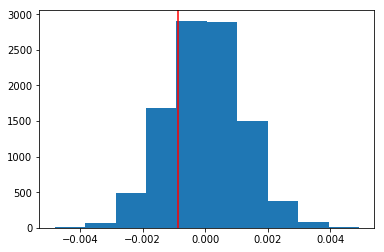

In [30]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
actual_diffs = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
(p_diffs > actual_diffs).mean()

0.90649999999999997

k. Explain what I just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The above value is called the p value. The p value is a number that describes the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct. A p value below .05 usually indicates that the null hypothesis should be rejected in favore of the new hypothesis. Alternatively a p value above .05 usually idicates that the null hypothesis should be failed to reject and change nothing. Since my calculated p value is .9, it indicates that I should fail to reject my null hypothesis as the new page does not perform any better than the old page.**

l. Calculating the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
#importing necessary library
import statsmodels.api as sm

convert_old = len(df2.query('converted==1 and landing_page=="old_page"'))
convert_new = len(df2.query('converted==1 and landing_page=="new_page"'))
n_old = len(df2.query('landing_page=="old_page"'))
n_new = len(df2.query('landing_page=="new_page"'))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Using `stats.proportions_ztest` to compute test statistic and p-value.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

print(z_score,p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p value is on par with the answer in part j. as the difference is minimal of .903 and .905. The z-score means that the difference between our test statistic (the difference between conversion rates) and the null hypothesis is 1.31 standard deviations above the mean. This is less than the critical 1.96 and suggests that the null hypothesis should be rejected. Therefore, the findings in this part coincide with the findings of part k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` Looking to see if the result I achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The type of regression to be used is logistic regression as I am exploring whether an event happens or not.**

b. Use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, I will first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. Also, I will need to add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Using **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [36]:
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d.Summary of the model b.

In [37]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-06 15:09 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**Hypothesis:**

$H_{0}$ : $p_{new}$ − $p_{old}$ = 0

$H_{1}$ : $p_{new}$ − $p_{old}$ ≠ 0

**This test is two sided T-test unlike the one sided T test in part II. The p value of the ab_page is .190. Although more significant, this is still higher than the p value's level of significance of .05. Therefore, I am still inclined to fail to reject the null hypothesis as found with previous conclusions.**

f. Are there any disadvantages to adding additional terms into your regression model?

**In short I would say there would not be a clear disadvantage to adding an additional term into my model. Adding additional terms could also lead to multicollinearity. Rather, I would find it advantageous to add additional terms as it gives a clearer picture on how certain aspects could affect conversion rates.**

g. Adding an effect based on which country a user lives in by reading in the **countries.csv** dataset and merging together the datasets on the appropriate rows.

Does it appear that country had an impact on conversion?

In [38]:
# Reading in countries.csv data in dataframe and joining to df2
countries = pd.read_csv('countries.csv')
df2 = df2.set_index('user_id').join(countries.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [39]:
#finding summary statistics for stats model
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-06 15:09 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**According to the summary statistics, there is no significance of conversion rates based on page recieved as found before.**

h. Looking at an interaction between page and country to see if there are significant effects on conversion, creating the necessary additional columns, and fitting the new model.

In [42]:
df2['CA_page'] = df2['CA']*df2['ab_page']
df2['UK_page'] = df2['UK']*df2['ab_page']
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'CA', 'UK', 'CA_page', 'UK_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-06 15:11 AIC:              212782.9259
No. Observations:   290584           BIC:              212835.8241
Df Model:           4                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
UK            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
CA_page      -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
UK_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
==================================================================

"""

**This summary statistic's conclusions are not much different than previous tests. The P value for Canada's page was .1947 which is not statistically significant as it is much higehr that .05. The same is found for the UK page as the P value is .6349, a much larger number. To conclude my findings, I am still inclined to fail to reject the null hypothesis which coincide with my previous findings. I have not found substantial evidence to conclude that the new page performed better and therefore, I do not find purpose in the new page being launched.**

### Should the new page replace the old page?
**No, the company should keep the old page for better performance. After stistically testing the data in several different ways, I was never able to reject the null in favor of the alternative.**

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0